In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.5 MB/s eta

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')

/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



\

hub://activeloop/nih-chest-xray-train loaded successfully.



In [ ]:
train_ds, val_ds = train_ds.random_split([0.9, 0.1])

In [ ]:
print(len(train_ds))
print(len(val_ds))

77872
8652


In [ ]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def save_results_to_file(result_file, train_loss, val_loss, micro_auc, macro_auc, per_class_auc_scores):
  with open(result_file, 'a') as f:
    f.write(f'{train_loss}, {val_loss}, {micro_auc}, {macro_auc},')

    for auc_score in per_class_auc_scores:
      f.write(f' {auc_score},')

    f.write('\n')

In [ ]:
def eval_one_epoch(model, criterion, data_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs)
      all_labels.append(labels)

      loss = criterion(outputs, labels)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device):
  model.train()

  running_train_loss = 0

  for i, data in enumerate(data_loader):
    inputs = data['images']
    labels = data['findings']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    running_train_loss += loss.item() * inputs.shape[0]

    loss.backward()
    optimizer.step()

    if i % 1000 == 999:
      print(f'Batch: {i + 1}/{len(data_loader)}')

  train_average_loss = running_train_loss / len(data_loader.dataset)
  print(f'Training phase completed. Average loss: {train_average_loss:.4f}')

  val_results = eval_one_epoch(model, criterion, val_data_loader, device)
  val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes = val_results

  return train_average_loss, val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes

In [ ]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [ ]:
def save_model(result_file_model, model, model_name, epoch):
  model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
  torch.save(model.state_dict(), model_save_path)
  print(f'Model saved at {model_save_path}')

In [ ]:
class SubNet(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, pool_kernel, pool_stride, dropout_rate):
    super(SubNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.LeakyReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.LeakyReLU(inplace=True)
    self.max_pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
    self.drop = nn.Dropout(dropout_rate)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu2(out)
    out = self.max_pool(out)
    out = self.drop(out)
    return out


class CustomNet(nn.Module):
  def __init__(self):
    super(CustomNet, self).__init__()
    self.block0 = SubNet(1, 32, 5, 1, 1, 2, 2, 0.1)
    self.block1 = SubNet(32, 64, 5, 1, 1, 2, 2, 0.1)
    self.block2 = SubNet(64, 128, 3, 1, 1, 2, 2, 0.1)
    self.block3 = SubNet(128, 256, 3, 1, 1, 2, 2, 0.1)
    self.block4 = SubNet(256, 512, 3, 1, 1, 2, 2, 0.1)
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(512, 256)
    self.fc2 = nn.Linear(256, 15)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.block0(x)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.avg_pool(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model is curretly running on: {device}")
model = CustomNet().to(device=device)

criterion = class_averaged_binary_cross_entropy
optimizer = optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

Model is curretly running on: cuda


------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [00:23<00:00, 91.6MB/s]


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1932
Validation phase completed. Average loss: 0.1908
Micro-averaged ROC AUC: 0.8704322070679944
Macro-averaged ROC AUC: 0.6749430389998702
ROC AUC for label 0: 0.660583770773365
ROC AUC for label 1: 0.8100308641975309
ROC AUC for label 2: 0.5686159487742737
ROC AUC for label 3: 0.5555602469057613
ROC AUC for label 4: 0.6370032257194972
ROC AUC for label 5: 0.7548949377182702
ROC AUC for label 6: 0.6909884854332426
ROC AUC for label 7: 0.7589908554090906
ROC AUC for label 8: 0.5785243116729308
ROC AUC for label 9: 0.6763353815180556
ROC AUC for label 10: 0.6817348976824507
ROC AUC for label 11: 0.6495554610733183
ROC AUC for label 12: 0.6768894293704001
ROC AUC for label 13: 0.6254967872962516
ROC AUC for label 14: 0.7989409814536149


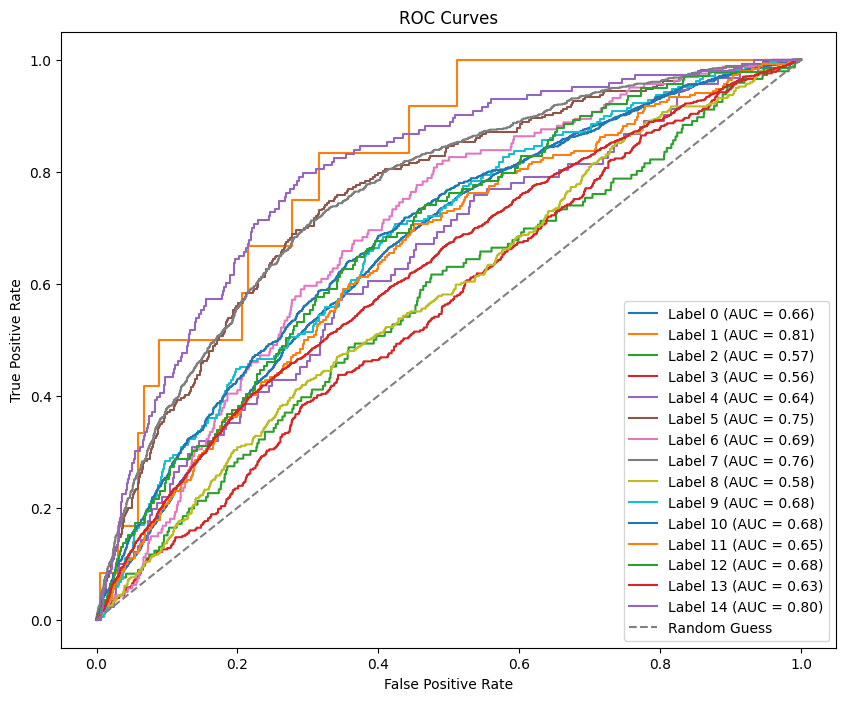

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_1.pt
------------------ Training Epoch 2 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1877
Validation phase completed. Average loss: 0.1839
Micro-averaged ROC AUC: 0.8854706193833216
Macro-averaged ROC AUC: 0.7088634334684522
ROC AUC for label 0: 0.6876958746811749
ROC AUC for label 1: 0.8635223765432098
ROC AUC for label 2: 0.6730816925361308
ROC AUC for label 3: 0.5506721532007323
ROC AUC for label 4: 0.6778516425753898
ROC AUC for label 5: 0.7667920771554526
ROC AUC for label 6: 0.7077438954362346
ROC AUC for label 7: 0.8025440341638848
ROC AUC for label 8: 0.6420110443093728
ROC AUC for label 9: 0.687759059687352
ROC AUC for label 10: 0.7254627565665189
ROC AUC for label 11: 0.6714732142857143
ROC AUC for label 12: 0.7044148306398932
ROC AUC for label 13: 0.6310270049975392
ROC AUC for label 14: 0.84089984

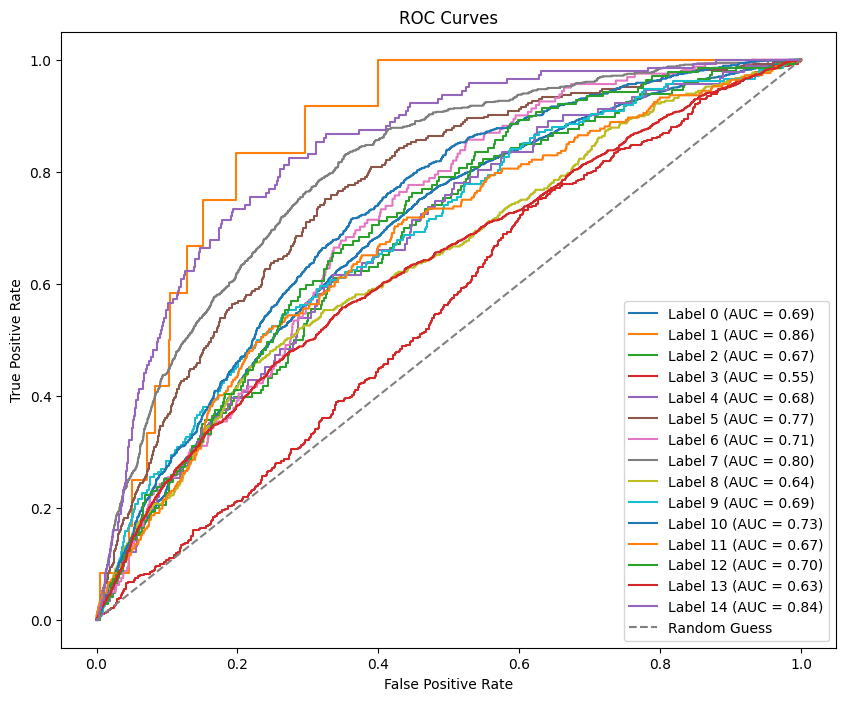

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_2.pt
------------------ Training Epoch 3 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1836
Validation phase completed. Average loss: 0.1797
Micro-averaged ROC AUC: 0.8937901280466014
Macro-averaged ROC AUC: 0.735184269328468
ROC AUC for label 0: 0.7153184621986887
ROC AUC for label 1: 0.8384741512345679
ROC AUC for label 2: 0.6919056330905823
ROC AUC for label 3: 0.5821846855563882
ROC AUC for label 4: 0.6741792257503039
ROC AUC for label 5: 0.7851936492864057
ROC AUC for label 6: 0.818114320533762
ROC AUC for label 7: 0.8281989332419247
ROC AUC for label 8: 0.6880606574465585
ROC AUC for label 9: 0.7114169027620887
ROC AUC for label 10: 0.7594168073524923
ROC AUC for label 11: 0.705561224489796
ROC AUC for label 12: 0.7364555436585771
ROC AUC for label 13: 0.6521653895609986
ROC AUC for label 14: 0.8411184537

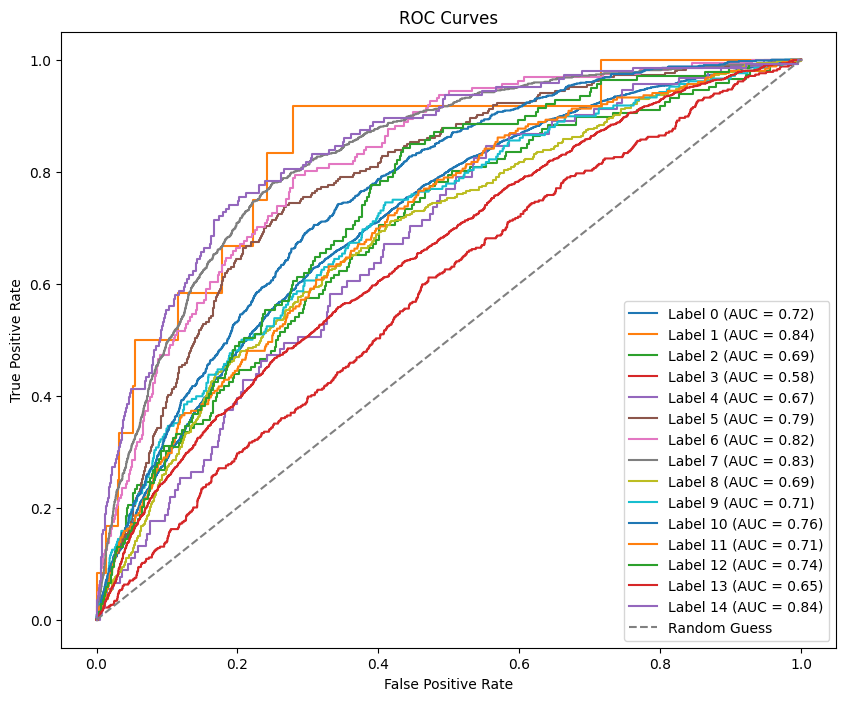

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_3.pt
------------------ Training Epoch 4 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1800
Validation phase completed. Average loss: 0.1765
Micro-averaged ROC AUC: 0.8989121083893299
Macro-averaged ROC AUC: 0.7519849132175745
ROC AUC for label 0: 0.7273986135221107
ROC AUC for label 1: 0.855979938271605
ROC AUC for label 2: 0.7246842679945502
ROC AUC for label 3: 0.6411639005293015
ROC AUC for label 4: 0.6632261559256067
ROC AUC for label 5: 0.7876005777631405
ROC AUC for label 6: 0.8498936762417788
ROC AUC for label 7: 0.839726725152911
ROC AUC for label 8: 0.7182979259650771
ROC AUC for label 9: 0.7470205289144772
ROC AUC for label 10: 0.7679449567511811
ROC AUC for label 11: 0.7287958238851096
ROC AUC for label 12: 0.707643494038318
ROC AUC for label 13: 0.6671360248845937
ROC AUC for label 14: 0.8532610884

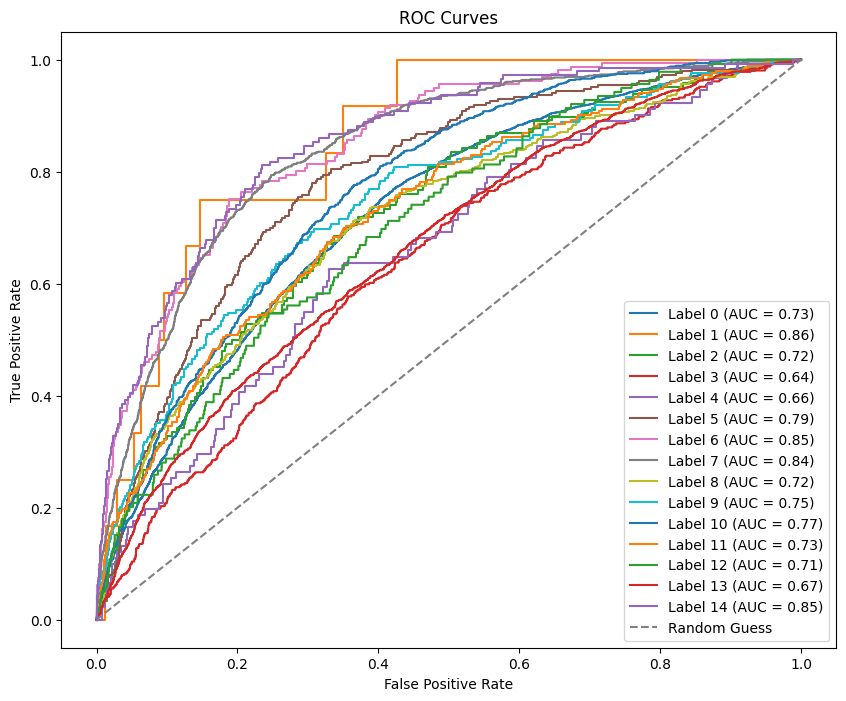

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_4.pt
------------------ Training Epoch 5 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1770
Validation phase completed. Average loss: 0.1756
Micro-averaged ROC AUC: 0.8997802582591169
Macro-averaged ROC AUC: 0.7616106420827808
ROC AUC for label 0: 0.7325585455038868
ROC AUC for label 1: 0.8671103395061729
ROC AUC for label 2: 0.7435649775017795
ROC AUC for label 3: 0.6432750081219001
ROC AUC for label 4: 0.6957862835680847
ROC AUC for label 5: 0.7862702681014897
ROC AUC for label 6: 0.8776329485878727
ROC AUC for label 7: 0.8454654290080241
ROC AUC for label 8: 0.7330080724884503
ROC AUC for label 9: 0.7257400566629013
ROC AUC for label 10: 0.7716793831200188
ROC AUC for label 11: 0.724358701814059
ROC AUC for label 12: 0.729849481157468
ROC AUC for label 13: 0.6730020056297698
ROC AUC for label 14: 0.874858130

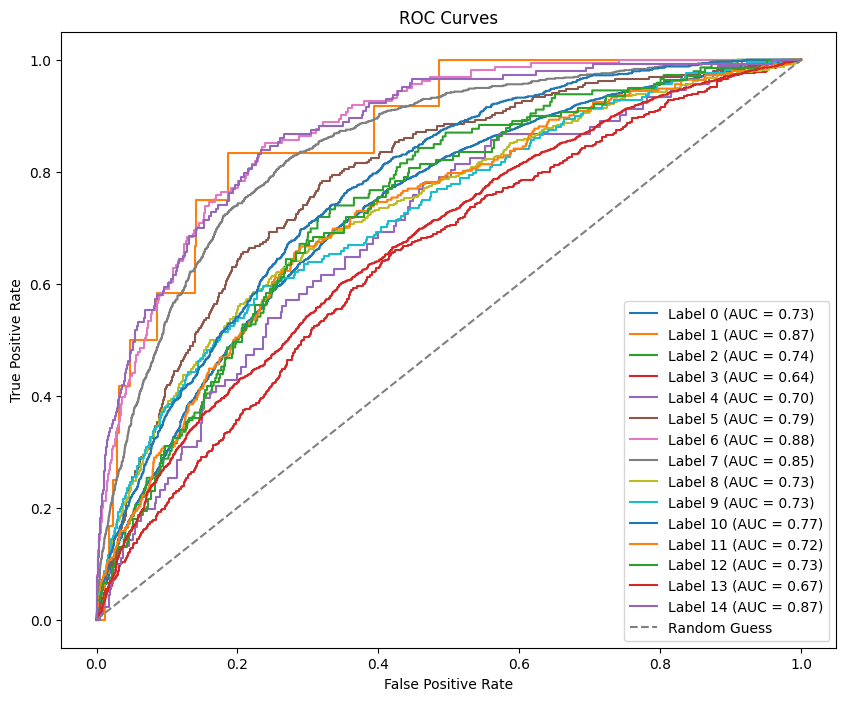

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_5.pt
------------------ Training Epoch 6 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1749
Validation phase completed. Average loss: 0.1732
Micro-averaged ROC AUC: 0.904406104976279
Macro-averaged ROC AUC: 0.7743094593871678
ROC AUC for label 0: 0.7453571185287322
ROC AUC for label 1: 0.9106770833333334
ROC AUC for label 2: 0.7432432867693715
ROC AUC for label 3: 0.6536619506868724
ROC AUC for label 4: 0.6949686220799407
ROC AUC for label 5: 0.781675412801399
ROC AUC for label 6: 0.8898695074287645
ROC AUC for label 7: 0.8549447351836129
ROC AUC for label 8: 0.7461200547138046
ROC AUC for label 9: 0.7477652543453703
ROC AUC for label 10: 0.7749466681604475
ROC AUC for label 11: 0.7500578703703703
ROC AUC for label 12: 0.7578219346289677
ROC AUC for label 13: 0.6764625923786068
ROC AUC for label 14: 0.887069799

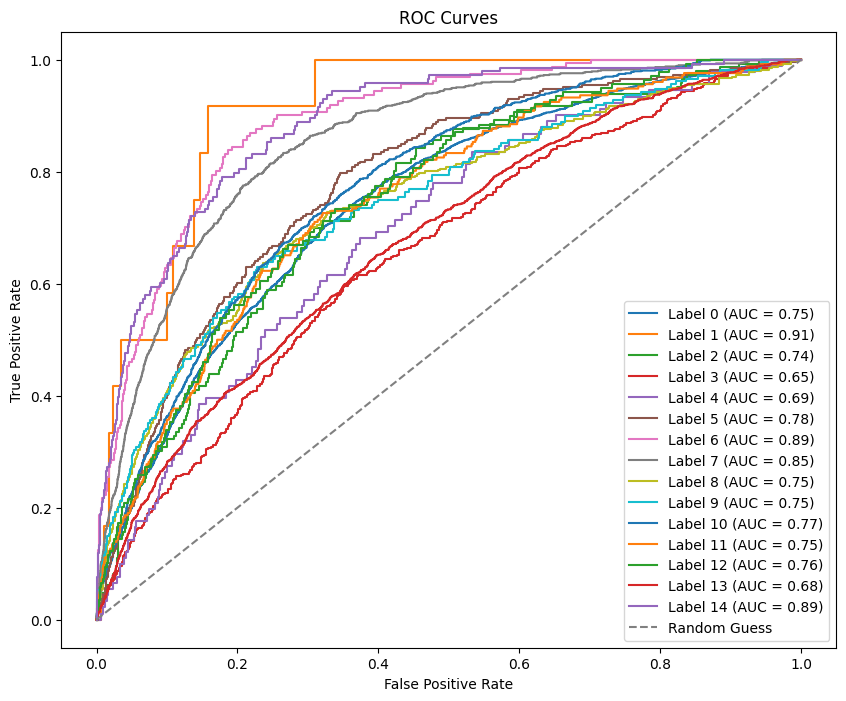

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_6.pt
------------------ Training Epoch 7 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1731
Validation phase completed. Average loss: 0.1731
Micro-averaged ROC AUC: 0.904553115529617
Macro-averaged ROC AUC: 0.7774414771796355
ROC AUC for label 0: 0.7460332752711001
ROC AUC for label 1: 0.9163580246913581
ROC AUC for label 2: 0.7423245154910796
ROC AUC for label 3: 0.6802063431746131
ROC AUC for label 4: 0.6861822910181745
ROC AUC for label 5: 0.7895853847324084
ROC AUC for label 6: 0.8769789861534062
ROC AUC for label 7: 0.8566061400508117
ROC AUC for label 8: 0.7592543653590166
ROC AUC for label 9: 0.7679189592974529
ROC AUC for label 10: 0.7878652970241568
ROC AUC for label 11: 0.7416095049130763
ROC AUC for label 12: 0.7584236381598352
ROC AUC for label 13: 0.6696032802065157
ROC AUC for label 14: 0.88267215

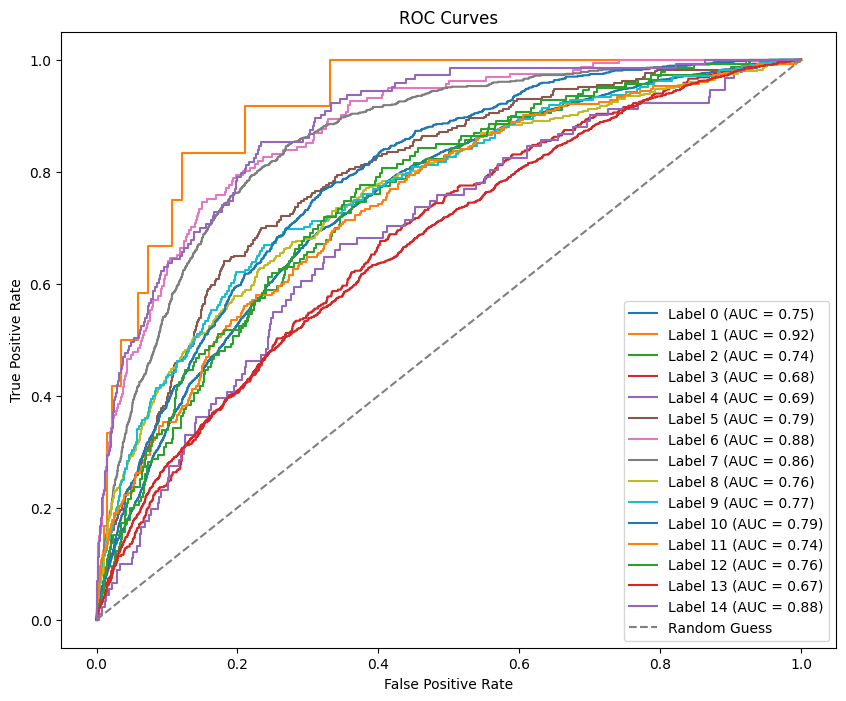

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_7.pt
------------------ Training Epoch 8 ------------------
Batch: 1000/4867
Batch: 2000/4867


In [ ]:
num_epochs = 10
model_name = "SSN_CustomNet"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_CustomNet.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 1} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 1)

In [ ]:
def load_model(result_file_model, model_to_load, model, epoch, device):
    model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f'Model loaded from {model_save_path}')
    return model

model_name = "SSN_CustomNet"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
epoch = 7

model = load_model(result_file_model, model_name, model, epoch, device)

criterion = class_averaged_binary_cross_entropy
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model is curretly running on: {device}")
model = CustomNet().to(device=device)

Model loaded from /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_CustomNet_checkpoint_epoch_7.pt
Model is curretly running on: cuda


In [ ]:
num_epochs = 10
model_name = "SSN_CustomNet"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_CustomNet.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 8} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 8)

------------------ Training Epoch 8 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [01:45<00:00, 20.4MB/s]


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.7373
